# Parametrised Notebook

## Required Modules

If this notebook is run though Google Colab, please uncomment the following cell to install B-FADE and mount your Google Drive in the curren workspace. Please also remember to delete the above cell.

In [1]:
# !pip install b-fade
# from google.cloud import drive
# drive.mount('/content/drive/')
## access your data through the default path /content/drive/My Drive/Colab Notebooks/YourDataFile.csv

Let us add to the path the source folder of B-FADE. The next cell is not necessary if you installed the module via package managers. So you just would skip the cell and jump over.

In [2]:
from sys import path as syspath
from os import path as ospath
syspath.append(ospath.join(ospath.expanduser("~"),
                           '/home/ale/Desktop/b-fade/src'))

First, import the required modules from both B-FADE and other Python packages.

In [3]:
import numpy as np

import scipy.stats
from sklearn.metrics import log_loss # Bernoulli likelihood from scikit-learn
import pandas as pd

from bfade.elhaddad import ElHaddadCurve, ElHaddadBayes, ElHaddadDataset
from bfade.dataset import SyntheticDataset
from bfade.viewers import BayesViewer, LaplacePosteriorViewer, PreProViewer
from bfade.statistics import MonteCarlo
from bfade.util import config_matplotlib, logger_manager

# add embellishments (labels, etc.) to the plots. This is optional,
# read the documentation of the module for further information
from bfade.elhaddad import ElHaddadTranslator


## Overview and Parameters
This section gathers all relevant parameters necessary to executed the notebook. A brief in-line explanation is provide besides each parameter -- unless the parameter is self-explains its function. We are going to read a noisy synthetic dataset generated upon an arbitrary reference EH curve (with parameters given below) and show it. The parameters $\Delta K_{th, lc}$ and $\Delta\sigma_{w}$ are labelled as `dk_th` and `ds_w`, respectively.

We shall initialise the Bayesian Infrastructure. In this case the likelihood is normalised, as we shall prescribe priors to facilitate the identification. Particularly, as we known the ground truth parameters we prescribe a Gaussian Prior centered there:

- $\Delta K_{th,lc} \sim \mathcal{N}(8, 0.5)$

- $\Delta\sigma_{w} \sim \mathcal{N}(700, 200)$

Note that the priors take the mean and **standard deviation** as input parameters. However, we must not anticipate a perfect match with the original parameters, but rather a trade of between those given by the likelihood and prior. After that, we set parameters for Bayesian infrastructure and plot utilities.

Following this we are going to configure the utilities to plot the results: Laplace posterior, prediction bands and predictive posterior.

In [4]:
# Configure logger
logger_level = "DEBUG"
logger_manager(level="DEBUG")

# Configure Matplotlib output. This affect look and feel of the plots (optional)
font_size = 12
font_family = "sans-serif" # remove serif from font
use_latex = False # render fonts through LaTeX compiler
config_matplotlib(font_size=font_size, font_family=font_family, use_latex=use_latex)

# Reference EH curve
dk_th = 8
ds_w = 700
Y = 0.9
eh_name = "EH-8-700" # name of the instance
x_ref = np.linspace(1,1000,1000) # x-coordinates for inspection

# Dataset
path_to_data = "./EH-7-800_Noisy.csv" # change with your location
x_range = [1,1000] # x-range for dataset plot
y_range = [100,1500] # y-range for dataset plot
data_scale = "log" # scale for the plot (logarithmic)

# Inference -- Configure ElHaddadBayes
# since we know the reference curve, inject prior around the expected parameter
# this can be changed in case of different scenarios/prior knowledge
mean_dk_th = 8 # mean for dk_{th, lc}
std_dk_th = 2 # std for dk_{th, lc}
mean_ds_w = 700 # mean for ds_{w}
std_ds_w = 200 # std for ds_{w}
# Inference -- Run MAP
guess = [5, 500] # initial choice of parameters for the optimiser

# Pre-Inference -- Configure BayesViewer
dk_th_range = [3,10] # range to plot for dk_th
dk_th_points = 25 # points along the axis for dk_th
ds_w_range = [600, 1200] # range to plot for ds_w
ds_w_points = 25 # points along the axis for ds_w

# Post-Inference -- Configure LaplacePosteriorViewer
dk_th_n_std = 4 # number of std dev over which the dk_th posterior is plotted
dk_th_n_points = 100 # number of points for dk_th posterior
ds_w_n_std = 4 # number of std dev over which the ds_w posterior is plotted
ds_w_n_points = 100 # number of points for ds_w posterior
# for practical reason we override the the bounds of the plot (optional)
dk_th_post_bounds = [3,10]
ds_w_post_bounds = [600,1200]

# Post-Inference -- Prediction bands (frequentist crack propagation region)
confidence_level = 95
monte_carlo_samples = 10000
monte_carlo_sampling = "joint" # choose whether sampling joint or marginal posterior

# Post-Inference -- Predictive posterior (Bayesian crack propagation region)
sqrt_area_bounds = [1,1000] # bounds of \sqrt{area} over the EH plane
delta_sigma_bounds = [100,1500] # bounds of \Delta\sigma over the EH plane
sqrt_area_points = 30 # bounds of \sqrt{area} over the EH plane
delta_sigma_points = 30 # bounds of \Delta\sigma  over the EH plane
post_grid_spacing = "log" 
posterior_samples = 50 # how many sample to draw from the posterior
post_op_1 = np.mean # function (numpy) to compute mean upon posterior samples
post_op_2 = np.std # function (numpy) to compute mean upon posterior samples

# Post-Inference -- Results, PreProViewer (show crack prop region over log-log EH plane)
sqrt_area_crack = sqrt_area_bounds
delta_sigma_crack = delta_sigma_bounds
sqrt_area_crack_curve = 1000 # resolution oif plotted curves along x-axis
crack_scale = post_grid_spacing

## Data Inspection
We instantiate the reference EH curve, load the dataset, and inspect both on the same canvas.

14:24:47 - bfade.dataset - DEBUG - ElHaddadDataset.config
14:24:47 - bfade.elhaddad - DEBUG - ElHaddadDataset.pre_process
14:24:47 - bfade.elhaddad - WARNING - Y_ref not user-provided
14:24:47 - bfade.elhaddad - WARNING - Verify uniqueness of Y
14:24:47 - bfade.elhaddad - WARNING - Y is unique = 0.90
14:24:47 - bfade.elhaddad - INFO - Update dataframe
14:24:47 - bfade.elhaddad - WARNING - Convert sqrt_area by 0.90
14:24:47 - bfade.elhaddad - INFO - Compute SIF range
14:24:47 - bfade.elhaddad - DEBUG - Calculate min max of delta_k for colour bars
14:24:47 - bfade.dataset - DEBUG - ElHaddadDataset.inspect
14:24:47 - bfade.util - DEBUG - SHOW PIC: Untitled_data


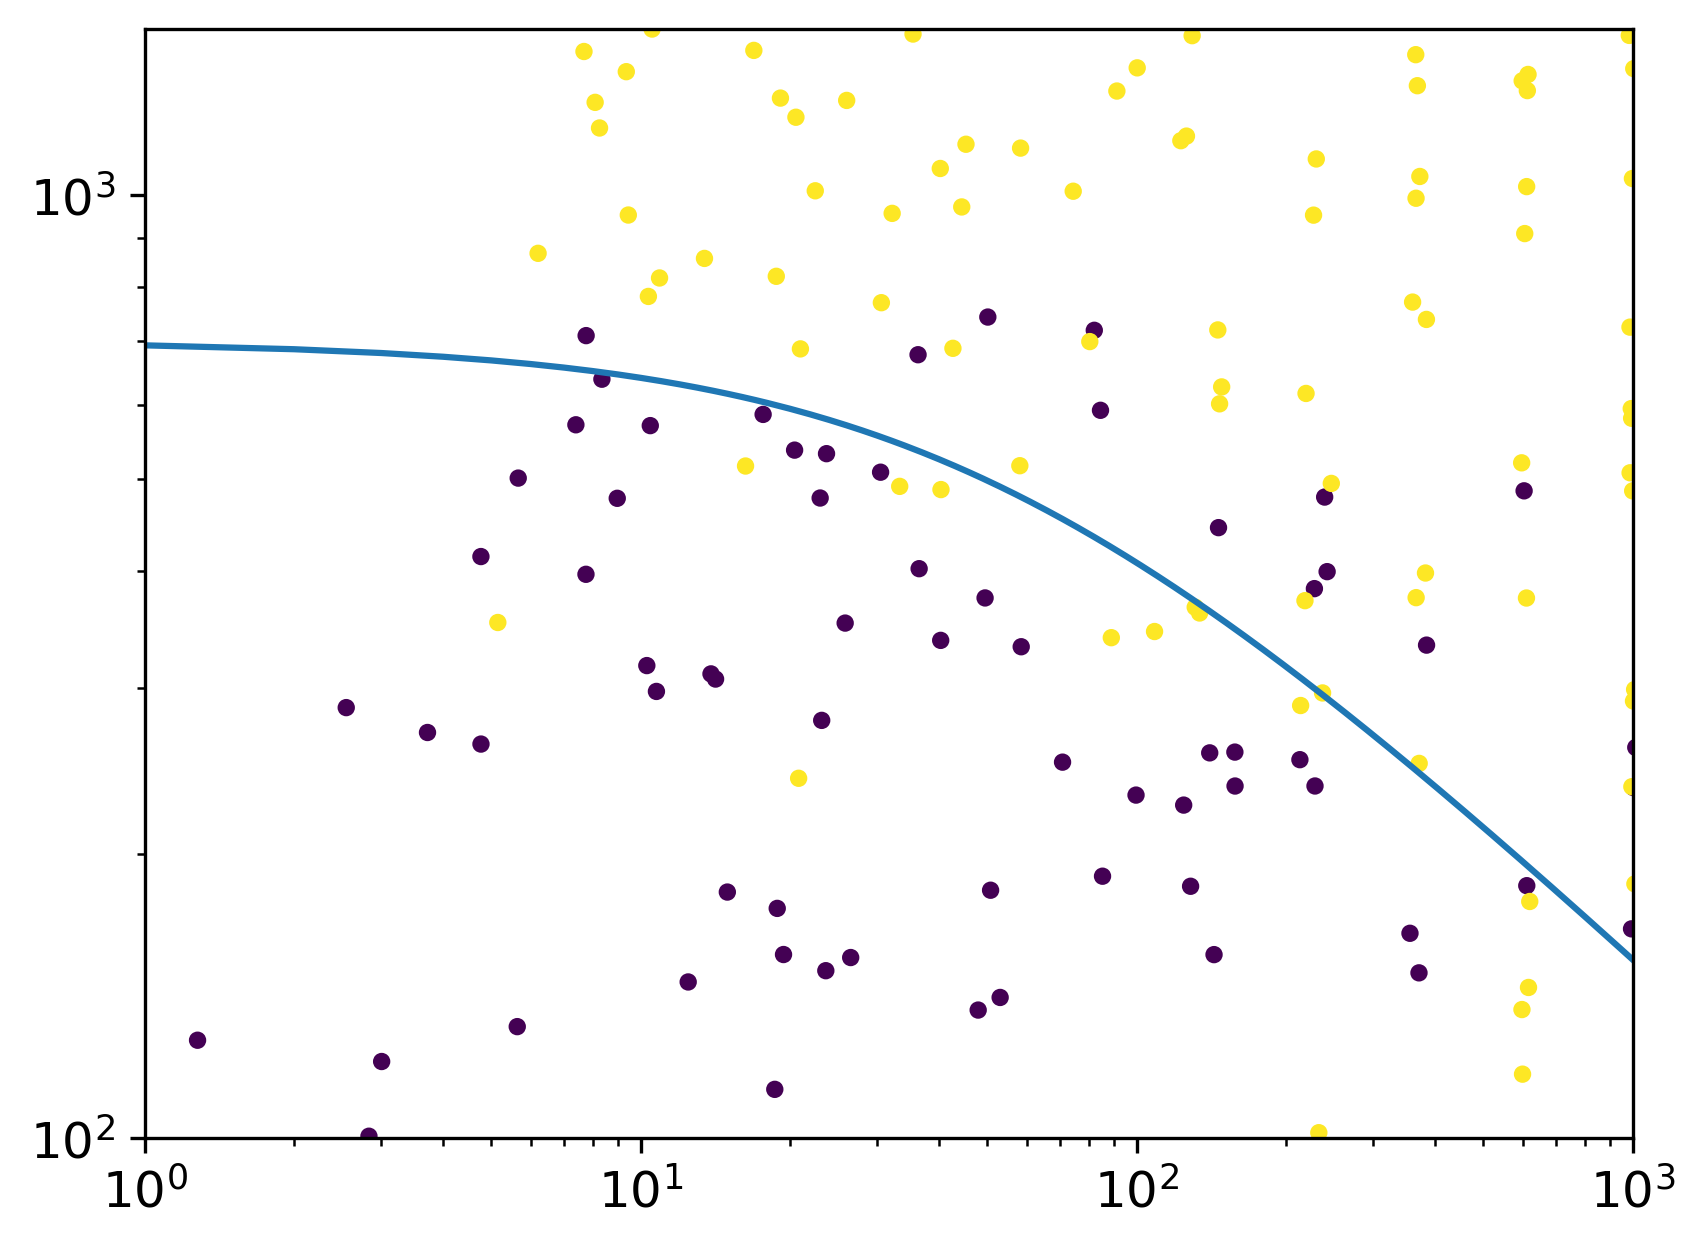

In [5]:
eh = ElHaddadCurve(metrics=np.log10, dk_th=dk_th, ds_w=ds_w, Y=Y, name="EH-8-700") # instantiation
sd = ElHaddadDataset(reader=pd.read_csv, path="/home/ale/Desktop/EH-7-800_Noisy.csv") # load dataset, change path if needed
sd.pre_process() # mandatory to populate the data structure
sd.inspect(x_range, y_range, scale=data_scale, curve=eh, x=x_ref)

## Bayesian Inference

### Pre-Inference
Before running MAP it is useful to display all Bayes elements. We configure `BayesViewer` and make contours.

In [6]:
bay = ElHaddadBayes("dk_th", "ds_w", Y=Y, name=eh_name)
bay.load_log_likelihood(log_loss, normalize=True)
bay.load_prior("dk_th", scipy.stats.norm, loc=mean_dk_th, scale=std_dk_th)
bay.load_prior("ds_w", scipy.stats.norm, loc=mean_ds_w, scale=std_ds_w)

14:24:47 - bfade.statistics - INFO - (Non-scipy). uniform.__init__
14:24:47 - bfade.statistics - INFO - (Non-scipy). uniform.__init__
14:24:47 - bfade.abstract - DEBUG - ElHaddadBayes.__init__ -- ElHaddadBayes({'name': 'EH-8-700', 'pars': ('dk_th', 'ds_w'), 'prior_dk_th': <bfade.statistics.Distribution object at 0x7f090c650f10>, 'prior_ds_w': <bfade.statistics.Distribution object at 0x7f090c650e80>})
14:24:47 - bfade.abstract - WARNING - ElHaddadBayes.MAP -- Optimal values unknown. Must run MAP.
14:24:47 - bfade.abstract - INFO - ElHaddadBayes.__init__ -- Deterministic parameter(s) {'Y': 0.9}
14:24:47 - bfade.abstract - INFO - ElHaddadBayes.load_log_likelihood -- <function log_loss at 0x7f0913f2d0d0>
14:24:47 - bfade.abstract - INFO - ElHaddadBayes.load_prior for dk_th
14:24:47 - bfade.abstract - INFO - ElHaddadBayes.load_prior for ds_w


Display the elements of the Bayes theorem in their logarithmic form.

14:24:47 - bfade.abstract - DEBUG - BayesViewer.__init__ -- BayesViewer(name = EH-8-700,
 pars = ('dk_th', 'ds_w'),
 p1 = dk_th,
 p2 = ds_w,
 n1 = 25,
 n2 = 25,
 b1 = [3, 10],
 b2 = [600, 1200],
 spacing = lin,
 bounds_dk_th = [3, 10],
 bounds_ds_w = [600, 1200])
14:24:47 - bfade.abstract - DEBUG - BayesViewer.config
14:24:47 - bfade.abstract - DEBUG - BayesViewer.config_contour
14:24:47 - bfade.abstract - DEBUG - BayesViewer.config_contour
14:24:47 - bfade.viewers - DEBUG - BayesViewer.contour. Contour: log_prior
14:24:47 - bfade.util - DEBUG - SHOW PIC: EH-8-700_bay_log_prior


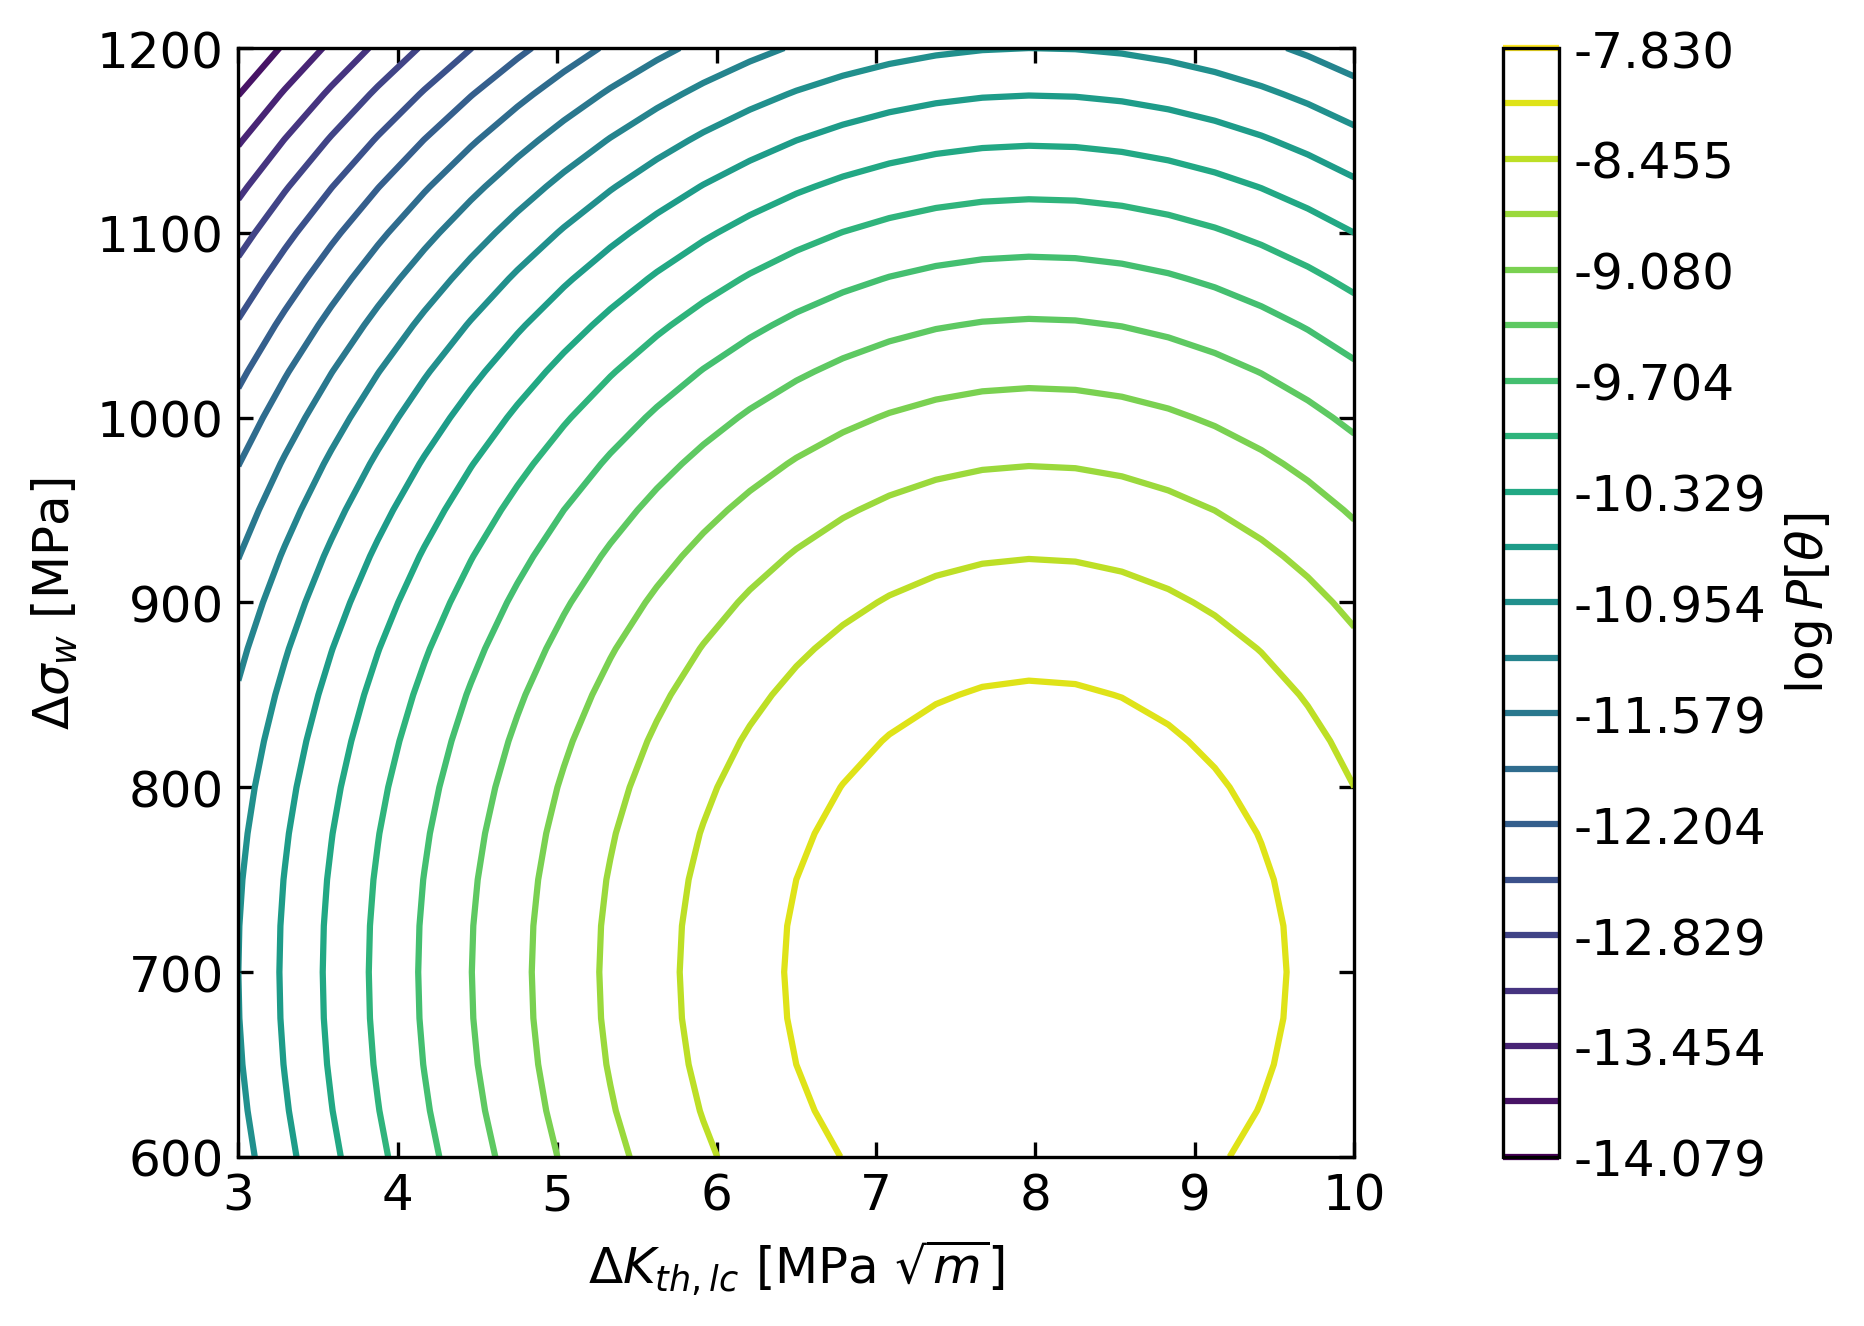

14:24:48 - bfade.viewers - DEBUG - BayesViewer.contour. Contour: log_likelihood
14:26:34 - bfade.util - DEBUG - SHOW PIC: EH-8-700_bay_log_likelihood


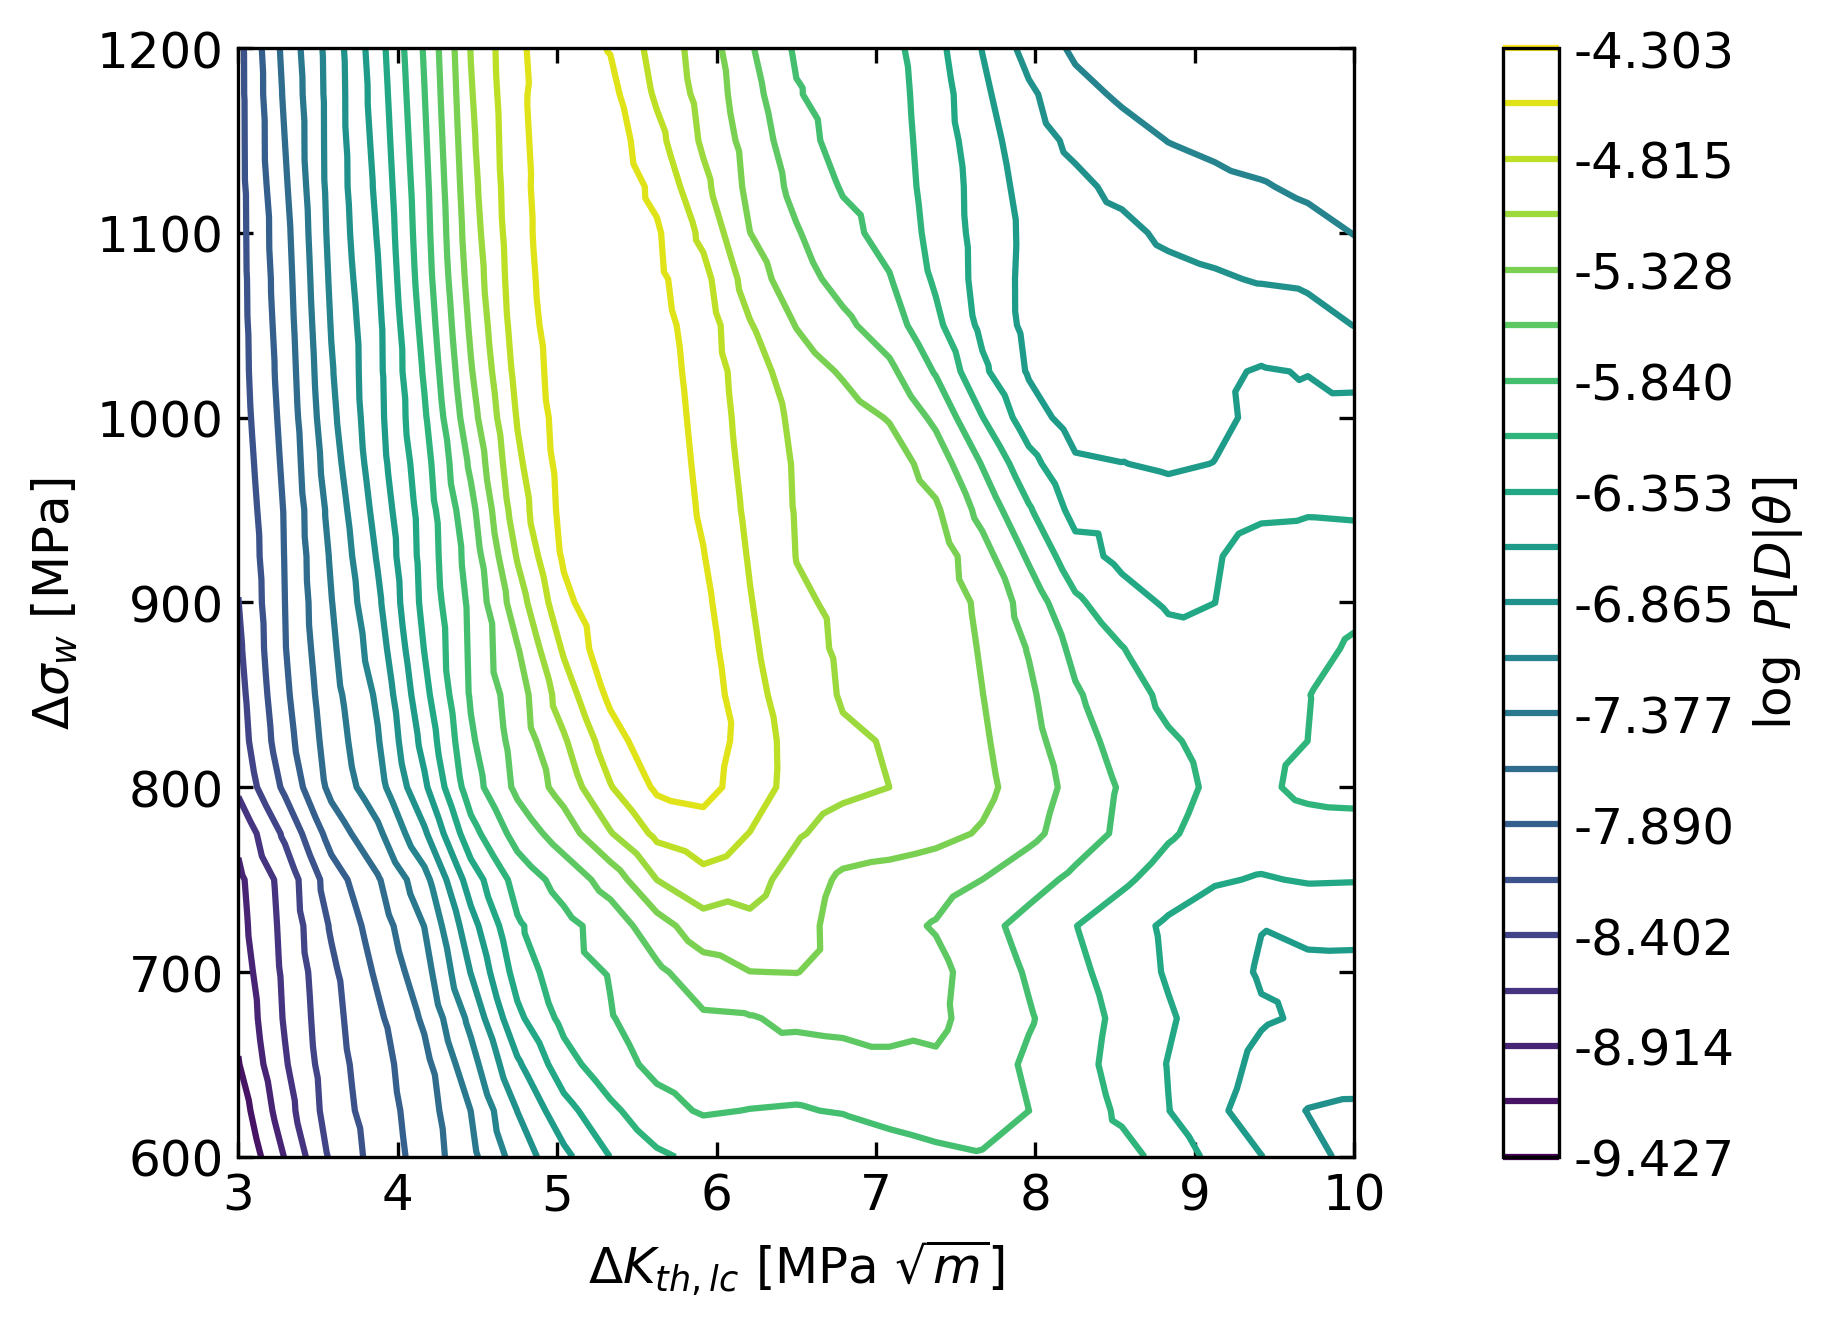

14:26:34 - bfade.viewers - DEBUG - BayesViewer.contour. Contour: log_posterior
14:28:20 - bfade.util - DEBUG - SHOW PIC: EH-8-700_bay_log_posterior


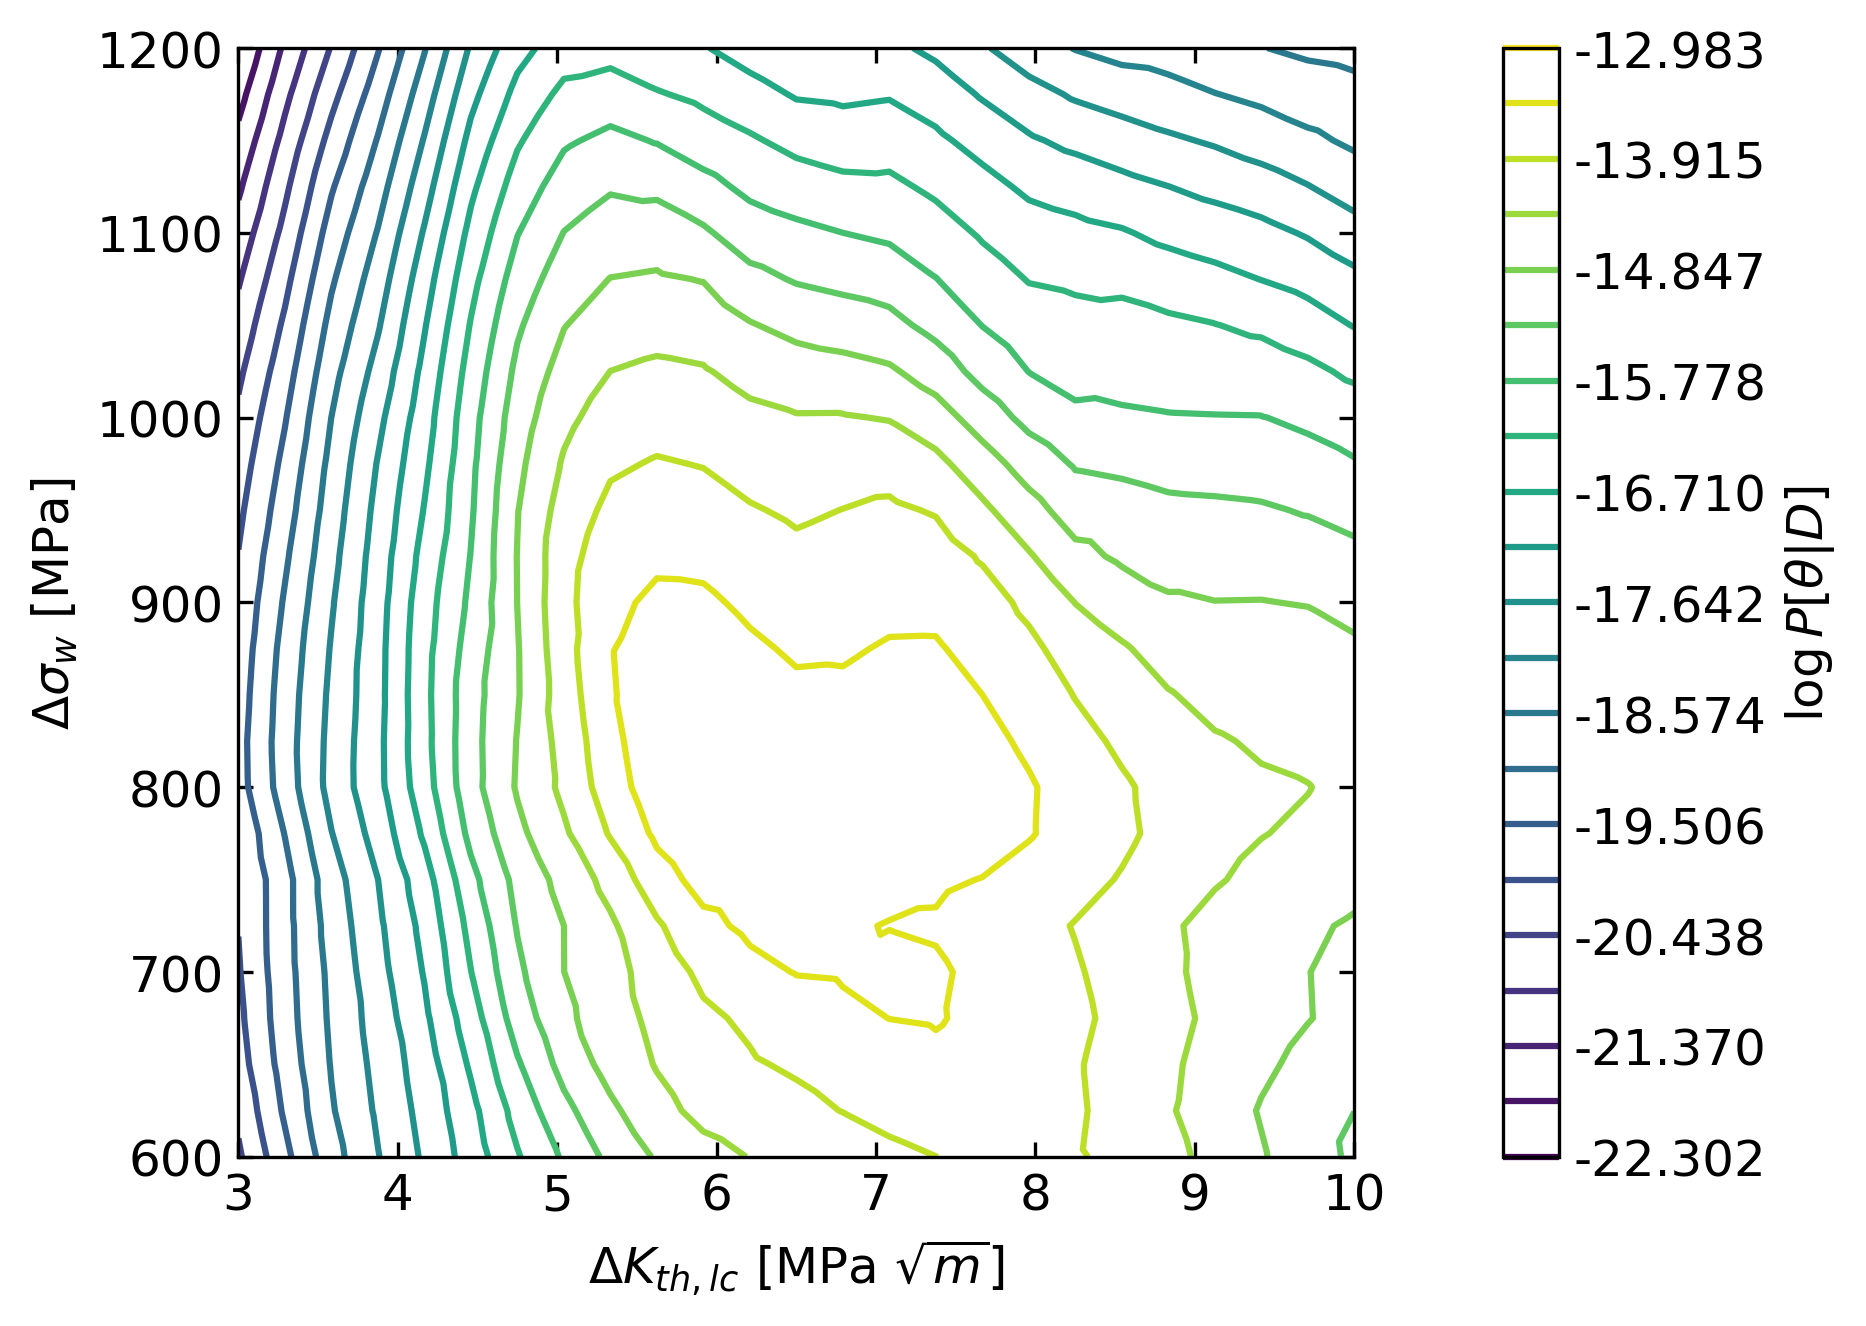

In [7]:
v = BayesViewer("dk_th", dk_th_range, dk_th_points,
                "ds_w",  ds_w_range,  ds_w_points, name=eh_name)
v.config_contour(translator=ElHaddadTranslator) # label x- and y- axis according to parameters 
v.contour("log_prior", bay)
v.contour("log_likelihood", bay, sd)
v.contour("log_posterior", bay, sd)

### Execute MAP
We run MAP initialising the optimiser nearby the stationary point of the posterior. As we shall see from the output, ``theta_hat`` is pretty close to the hypothesised values despite the noisy data, owing to the prescribed prior distribution.

In [8]:
bay.MAP(sd, x0=guess)

14:28:20 - bfade.abstract - INFO - ElHaddadBayes.MAP -- Default solver Nelder-Mead, {'disp': True, 'maxiter': 10000000000.0}
14:28:20 - bfade.abstract - WARNING - ElHaddadBayes.MAP -- Run MAP.
14:28:21 - bfade.abstract - INFO - Iter: 0 -- Params: [  5.375 537.5  ] -- Min 15.704
14:28:22 - bfade.abstract - INFO - Iter: 1 -- Params: [  5.375 537.5  ] -- Min 15.704
14:28:22 - bfade.abstract - INFO - Iter: 2 -- Params: [  5.75 600.  ] -- Min 14.670
14:28:23 - bfade.abstract - INFO - Iter: 3 -- Params: [  5.75 600.  ] -- Min 14.670
14:28:23 - bfade.abstract - INFO - Iter: 4 -- Params: [  6.875 687.5  ] -- Min 13.446
14:28:24 - bfade.abstract - INFO - Iter: 5 -- Params: [  6.9375 781.25  ] -- Min 13.196
14:28:24 - bfade.abstract - INFO - Iter: 6 -- Params: [  7.484375 801.5625  ] -- Min 13.137
14:28:25 - bfade.abstract - INFO - Iter: 7 -- Params: [  7.484375 801.5625  ] -- Min 13.137
14:28:25 - bfade.abstract - INFO - Iter: 8 -- Params: [  7.484375 801.5625  ] -- Min 13.137
14:28:26 - bfade.

Optimization terminated successfully.
         Current function value: 13.095508
         Iterations: 49
         Function evaluations: 97


14:29:06 - bfade.abstract - DEBUG - ElHaddadBayes.laplace_posterior -- Load distributions.
14:29:06 - bfade.abstract - WARNING - ElHaddadBayes.MAP -- theta_hat [  7.24471549 794.40804652]
14:29:06 - bfade.abstract - WARNING - ElHaddadBayes.MAP -- ihess [[ 3.61100685e-01 -1.21466812e+00]
 [-1.21466812e+00  7.07557169e+02]]


## Post-Inference

### Laplace Posterior
Once MAP is accomplished, it is possible to display the approximated Laplace posterior. To do so the user is required to instantiate a specific viewer, i.e. `LaplacePosteriorViewer`.

14:29:06 - bfade.viewers - DEBUG - LaplacePosteriorViewer.__init__
14:29:06 - bfade.abstract - DEBUG - LaplacePosteriorViewer.__init__ -- LaplacePosteriorViewer(c1 = 4,
 c2 = 4,
 name = Untitled,
 pars = ('dk_th', 'ds_w'),
 p1 = dk_th,
 p2 = ds_w,
 n1 = 100,
 n2 = 100,
 b1 = [4.84104934 9.64838164],
 b2 = [688.00825941 900.80783363],
 spacing = lin,
 bounds_dk_th = [4.84104934 9.64838164],
 bounds_ds_w = [688.00825941 900.80783363])
14:29:06 - bfade.abstract - DEBUG - LaplacePosteriorViewer.config
14:29:06 - bfade.abstract - DEBUG - LaplacePosteriorViewer.config_contour
14:29:06 - bfade.abstract - DEBUG - LaplacePosteriorViewer.config_contour
14:29:06 - bfade.viewers - DEBUG - LaplacePosteriorViewer.contour -- joint poterior
14:29:07 - bfade.util - DEBUG - SHOW PIC: Untitled_laplace_joint


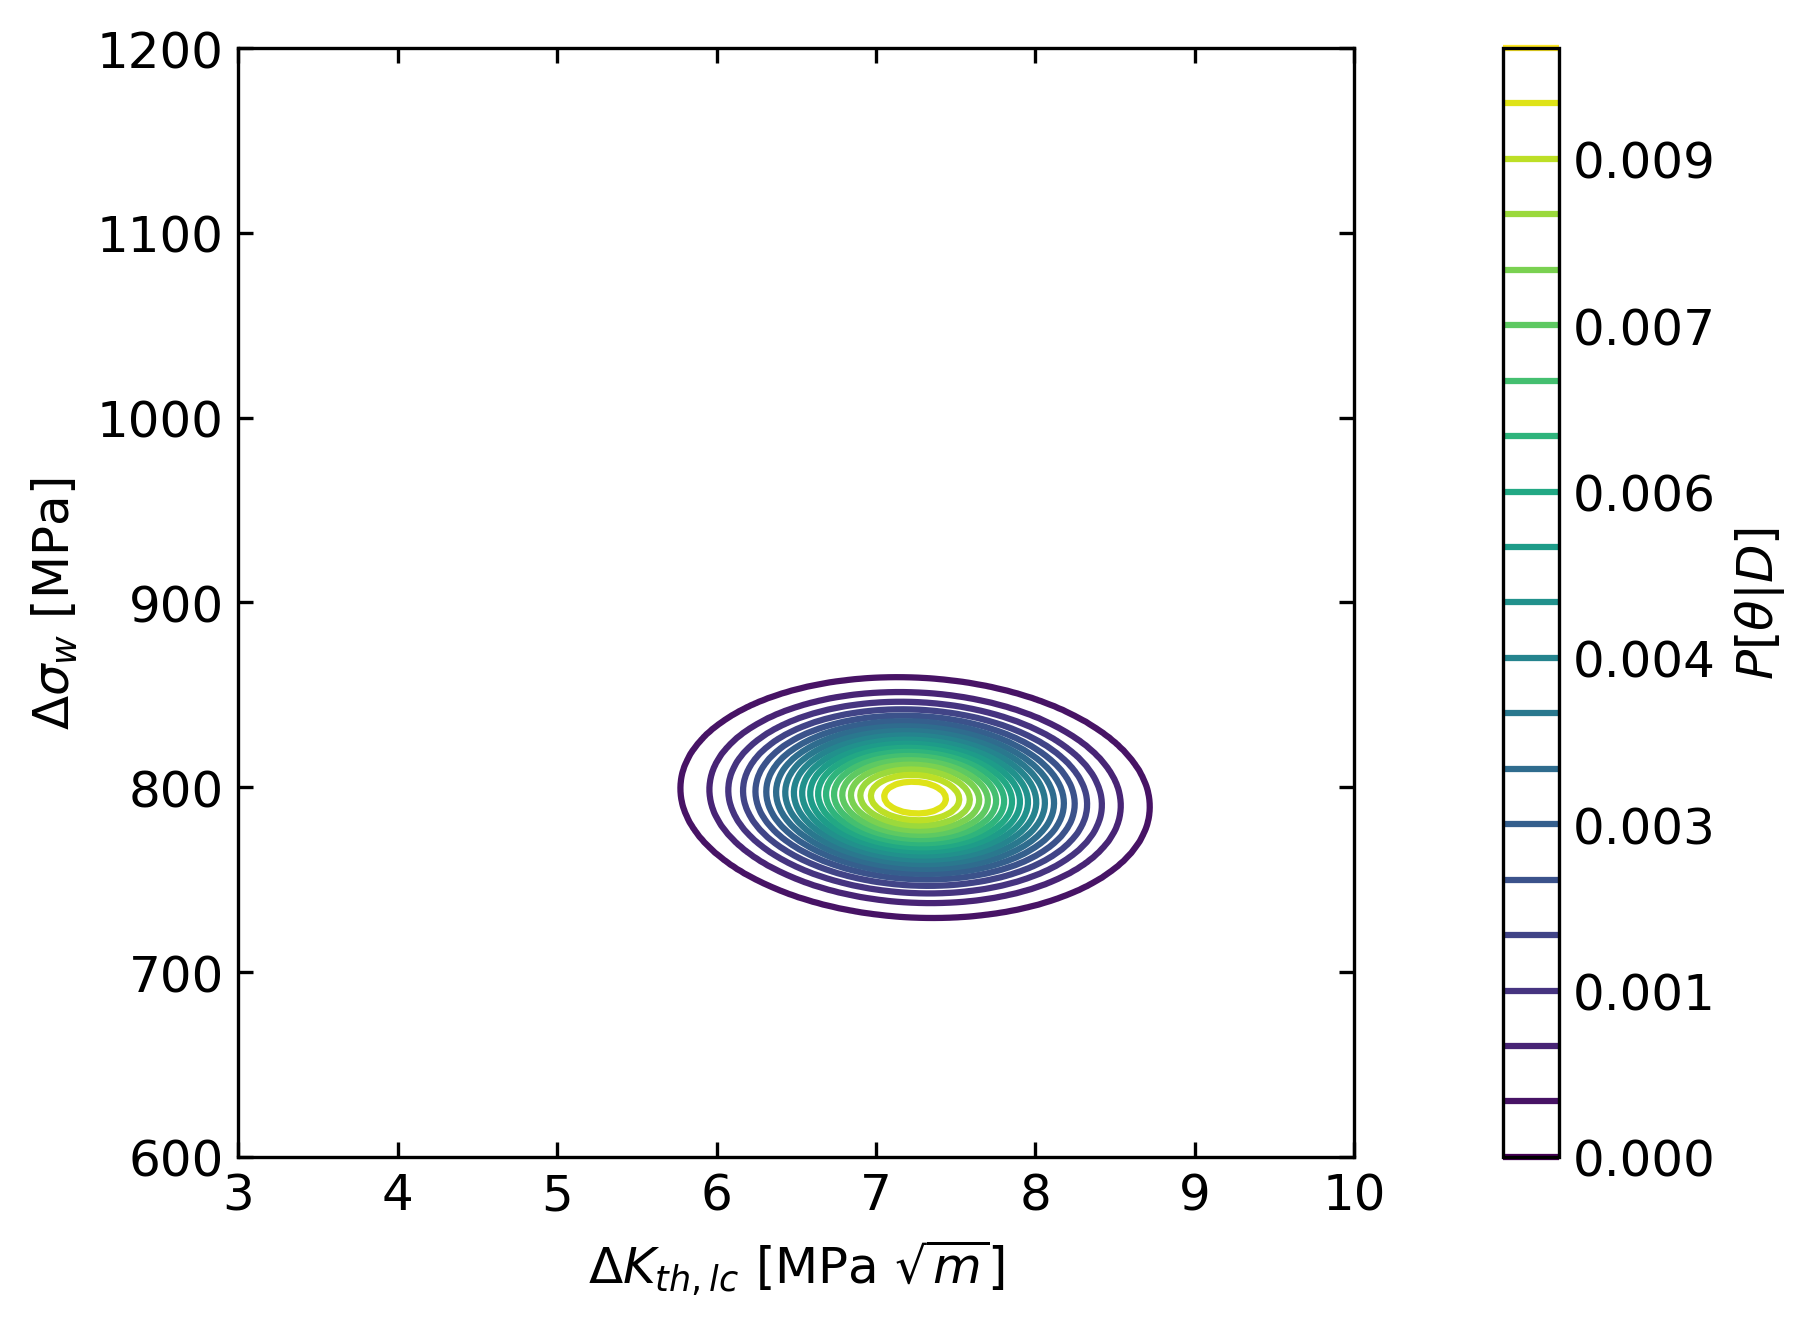

14:29:07 - bfade.viewers - DEBUG - LaplacePosteriorViewer.marginals
14:29:07 - bfade.util - DEBUG - SHOW PIC: Untitled_lap_marginal_dk_th


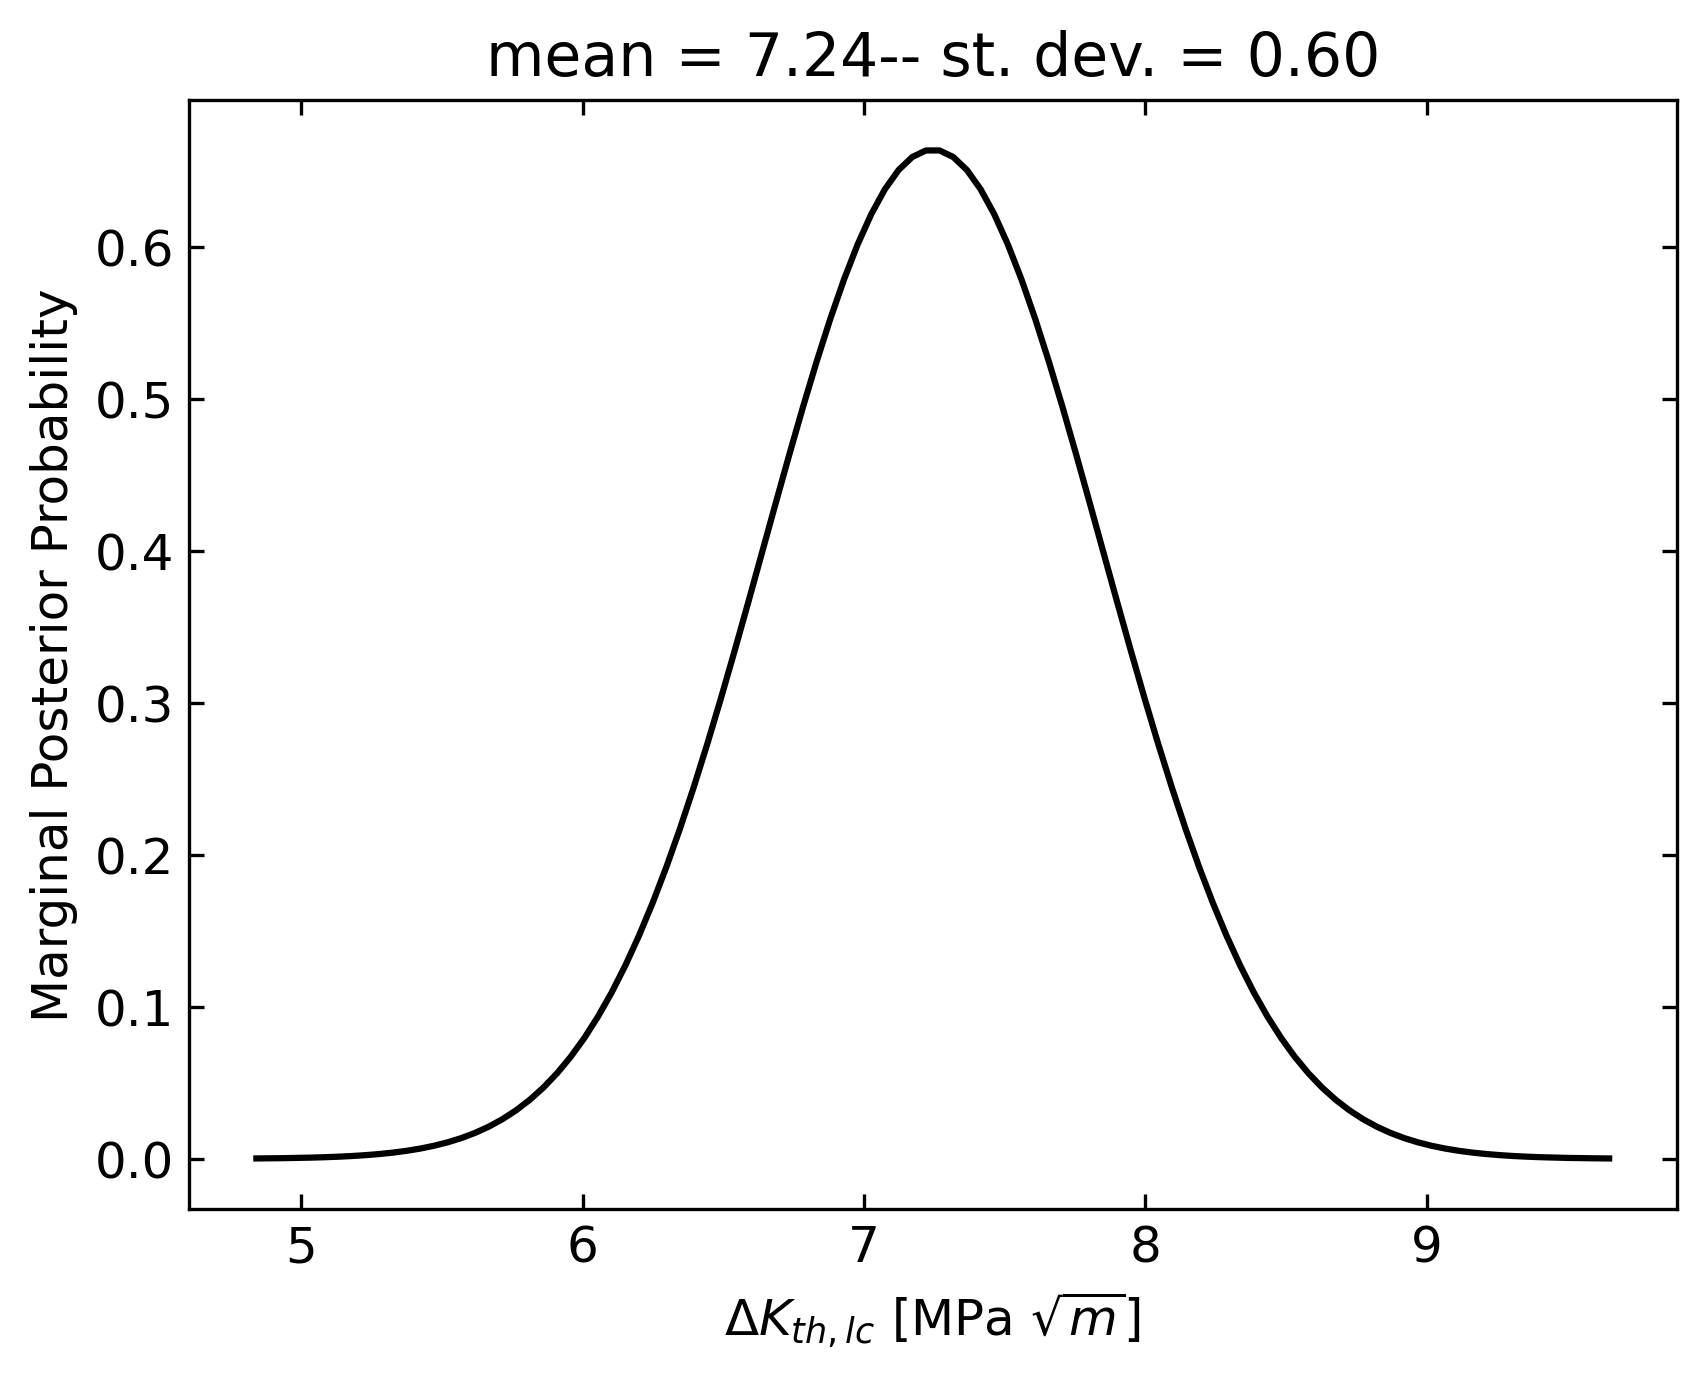

14:29:07 - bfade.viewers - DEBUG - LaplacePosteriorViewer.marginals
14:29:07 - bfade.util - DEBUG - SHOW PIC: Untitled_lap_marginal_ds_w


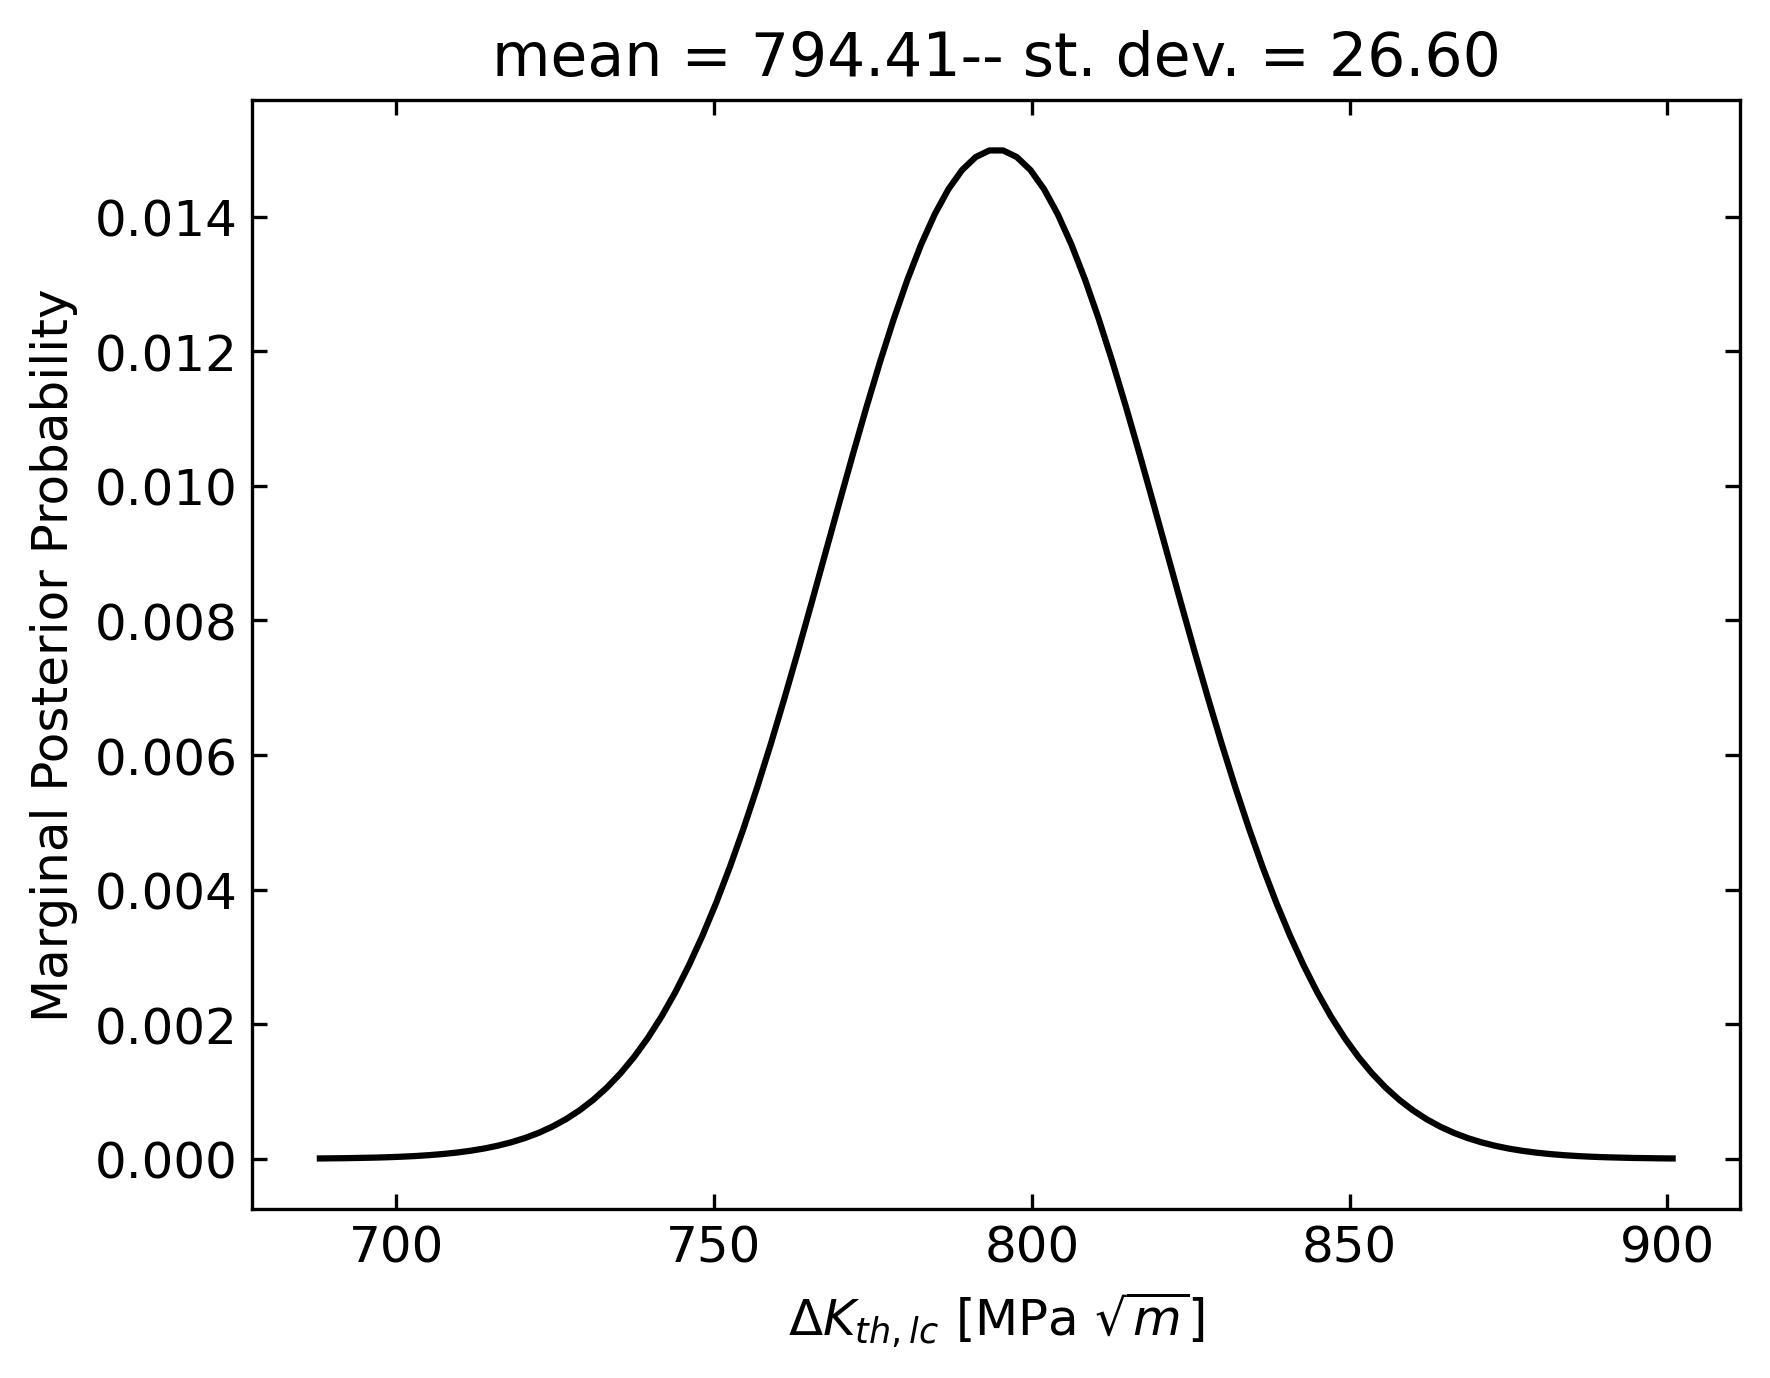

In [9]:
l = LaplacePosteriorViewer("dk_th", dk_th_n_std, dk_th_n_points, 
                           "ds_w",  ds_w_n_std,  ds_w_n_points, bay)
# override bounds
l.config_contour(xlim=dk_th_post_bounds, ylim=ds_w_post_bounds,
                  translator=ElHaddadTranslator)
l.contour(bay) # plot joint distribution
l.marginals("dk_th", bay) # plot marginal distribution dk_th
l.marginals("ds_w", bay) # plot marginal distribution of ds_w

### Inspecting Results
Finally, we display the results of the Bayesian Inference along with the training data. Since we ran MAP the predictive posterior is available too.

Furthermore, we instantiate a `MonteCarlo` object to compute the prediction intervals for the estimated EH curve. In this regard, we do not run explicitly a Monte Carlo simulation, but we rely on the interface of PreProViewer to trigger the computations. Similarly, the predictive posterior is not directly computed, though the computation are triggered via the interface of the viewer.

As for the predictive posterior, an evaluation grid is required. We generate a regular log-spaced grid of points

14:29:07 - bfade.viewers - DEBUG - PreProViewer.__init__ -- PreProViewer(x_edges = [1, 1000],
 y_edges = [100, 1500],
 x_scale = log,
 y_scale = log,
 n = 1000,
 name = EH-8-700,
 det_pars = {})
14:29:07 - bfade.viewers - DEBUG - PreProViewer.config
14:29:07 - bfade.viewers - DEBUG - PreProViewer.config_canvas
14:29:07 - bfade.viewers - DEBUG - PreProViewer.config_canvas
14:29:07 - bfade.statistics - DEBUG - MonteCarlo.__init__
14:29:07 - bfade.dataset - DEBUG - SyntheticDataset.config
14:29:07 - bfade.dataset - DEBUG - SyntheticDataset.make_grid
14:29:07 - bfade.viewers - INFO - Inspect training data
14:29:07 - bfade.viewers - DEBUG - PreProViewer.add_colourbar
14:29:07 - bfade.viewers - DEBUG - State: EH-8-700_train
14:29:07 - bfade.viewers - INFO - Inspect given curves
14:29:07 - bfade.viewers - DEBUG - State: EH-8-700_train_EH-8-700
14:29:07 - bfade.viewers - DEBUG - State: EH-8-700_train_EH-8-700_EH-8-700-Estimated
14:29:07 - bfade.viewers - INFO - Inspect prediction interval
14:2

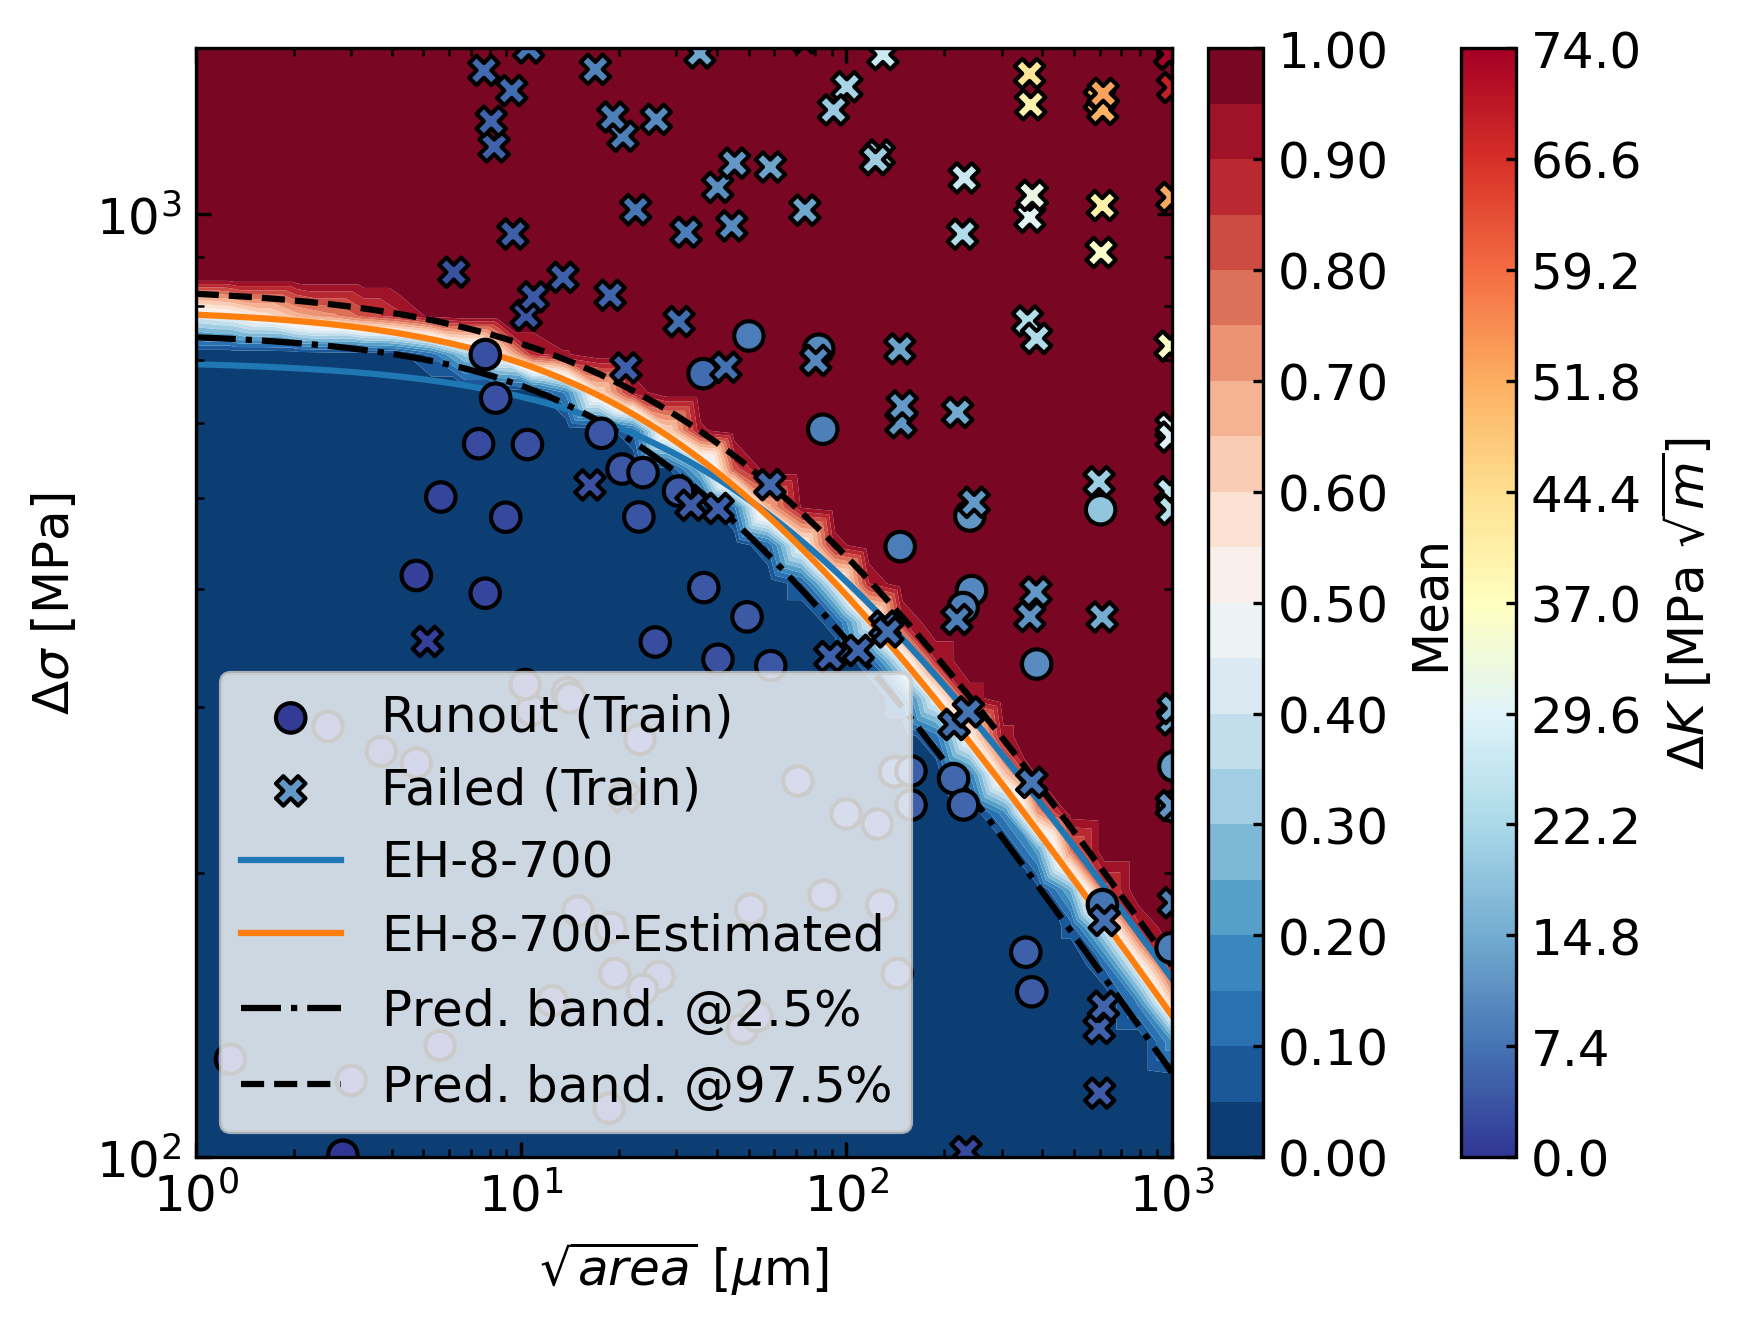

14:29:51 - bfade.viewers - INFO - Inspect training data
14:29:51 - bfade.viewers - DEBUG - PreProViewer.add_colourbar
14:29:51 - bfade.viewers - DEBUG - State: EH-8-700_train
14:29:51 - bfade.viewers - INFO - Inspect given curves
14:29:51 - bfade.viewers - DEBUG - State: EH-8-700_train_EH-8-700
14:29:51 - bfade.viewers - DEBUG - State: EH-8-700_train_EH-8-700_EH-8-700-Estimated
14:29:51 - bfade.viewers - INFO - Inspect prediction interval
14:29:51 - bfade.statistics - DEBUG - MonteCarlo.sample -- Joint, samples = 10000
14:29:51 - bfade.statistics - INFO - MonteCarlo.prediction_interval -- Confidence = 0.95%
14:29:51 - bfade.viewers - DEBUG - State: EH-8-700_train_EH-8-700_EH-8-700-Estimated_pi
14:29:51 - bfade.viewers - INFO - Inspect predictive posterior
14:29:51 - bfade.abstract - DEBUG - ElHaddadBayes.predictive_posterior
14:30:34 - bfade.abstract - DEBUG - ElHaddadBayes.predictive_posterior -- Return prediction stack
14:30:34 - bfade.viewers - DEBUG - State: EH-8-700_train_EH-8-700

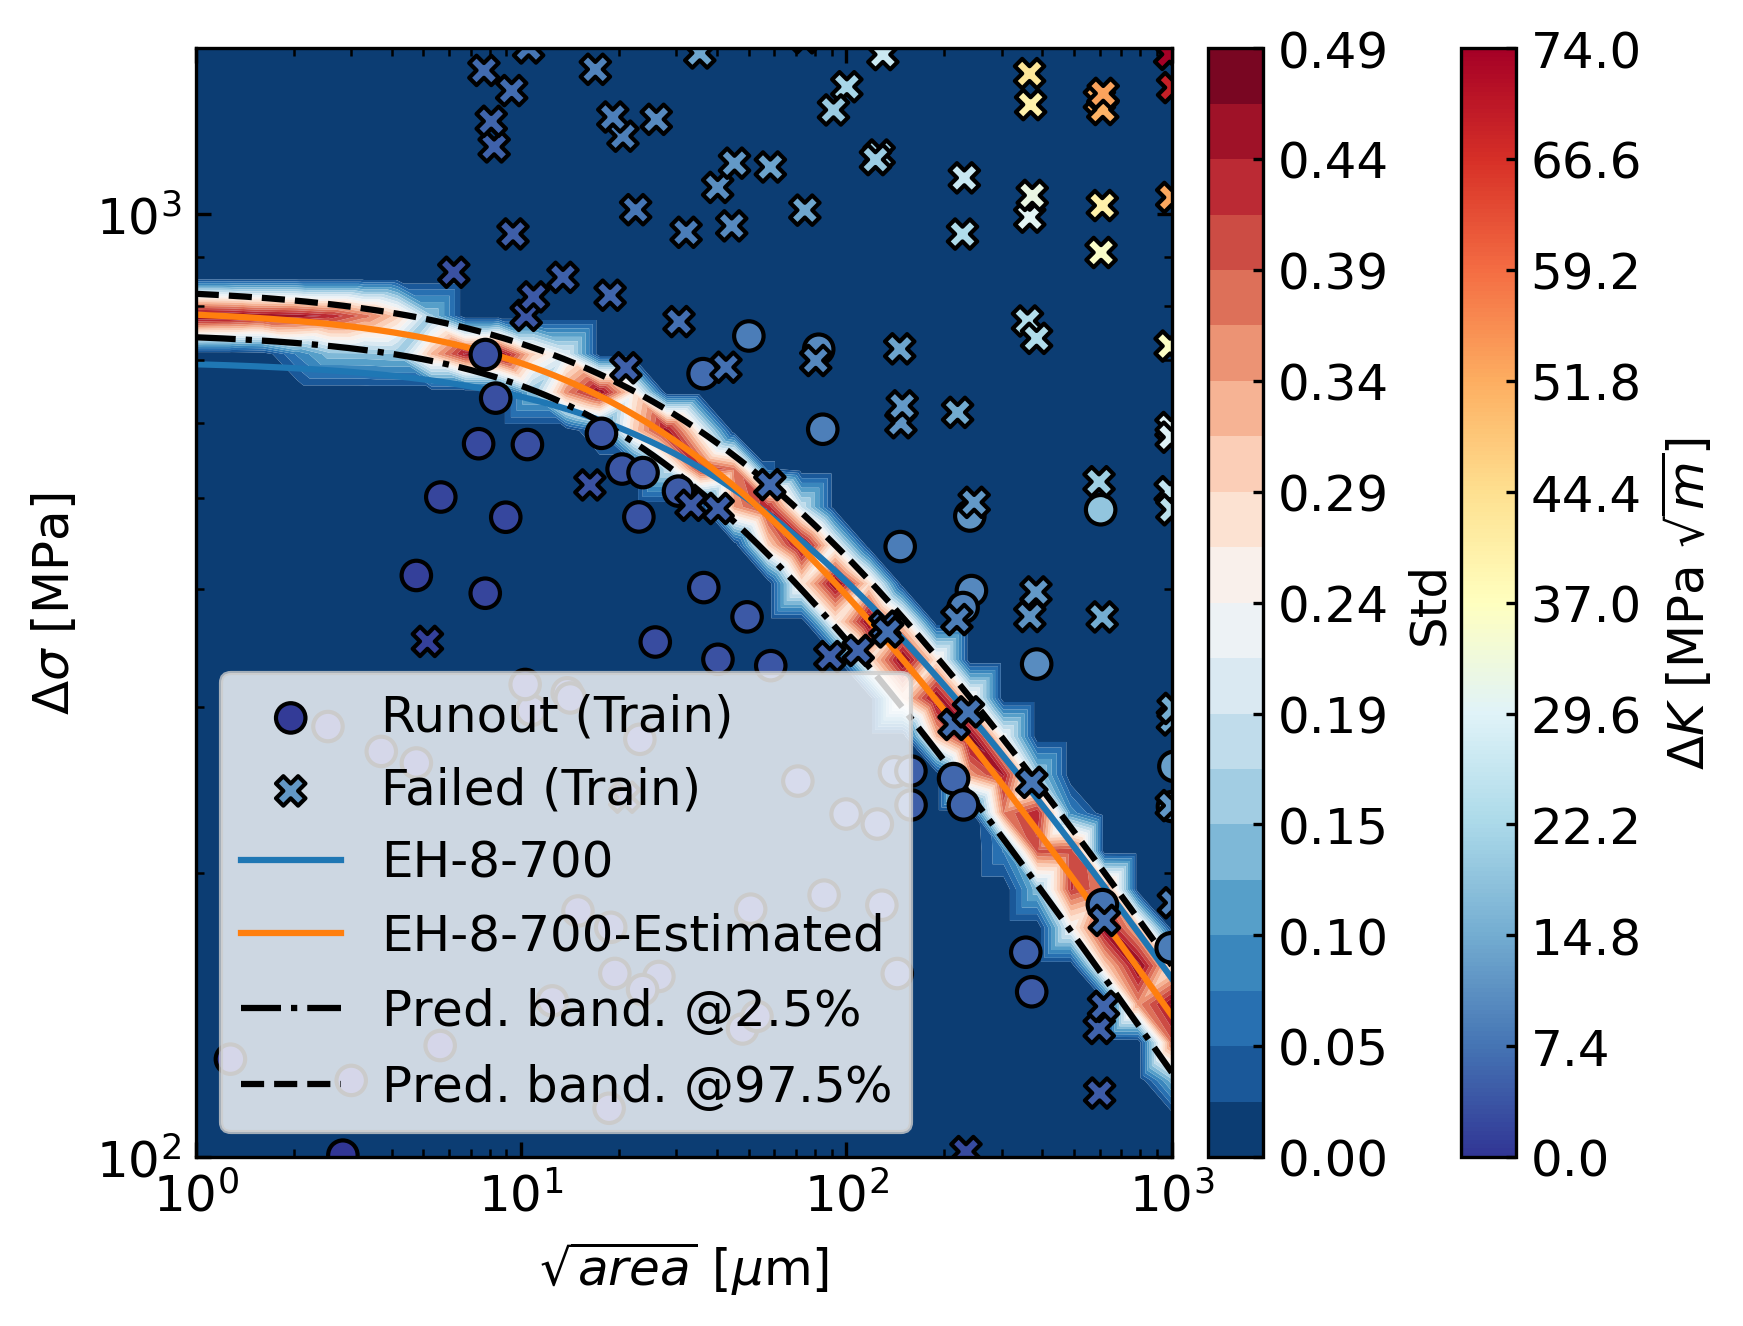

In [10]:
# Instantiate the viewer
p = PreProViewer(sqrt_area_crack, delta_sigma_crack, sqrt_area_crack_curve,
                 scale=crack_scale, name=eh_name)
p.config_canvas(xlabel="sq_a", ylabel="ds", cbarlabel="dk",
                translator=ElHaddadTranslator) # load axis label (optional)

opt = ElHaddadCurve(dk_th=bay.theta_hat[0], ds_w=bay.theta_hat[1], Y=0.9,
                    name=eh_name + "-Estimated") # retrieve the estimated EH curve through MAP

# Instantiate MonteCarlo object to probe ElHaddadCurve (for prediction bands)
mc = MonteCarlo(ElHaddadCurve)
eval_grid = SyntheticDataset(name=eh_name + "_Eval")
eval_grid.make_grid(sqrt_area_crack, delta_sigma_crack,
                    sqrt_area_points, delta_sigma_points, spacing=crack_scale)

p.view(train_data=sd, curve=[eh, opt], # pass eval grid as train data along with the curves to plot
       prediction_interval=mc,
       mc_bayes=bay,
       mc_samples=monte_carlo_samples,
       mc_distribution=monte_carlo_sampling,
       confidence=confidence_level,
       predictive_posterior=bay,
       post_samples=posterior_samples,
       post_op=post_op_1, # mean
       post_data=eval_grid
       )

p.view(train_data=sd, curve=[eh, opt], # pass eval grid as train data along with the curves to plot
       prediction_interval=mc,
       mc_bayes=bay,
       mc_samples=monte_carlo_samples,
       mc_distribution=monte_carlo_sampling,
       confidence=confidence_level,
       predictive_posterior=bay,
       post_samples=posterior_samples,
       post_op=post_op_2, #std
       post_data=eval_grid)